<a href="https://colab.research.google.com/github/BagiyaLakshmi/image-shadow-removal-challenge/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import cv2
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy.misc
from skimage.metrics import structural_similarity as ssim
import torch.optim.lr_scheduler as lr_scheduler
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir ./datasets
!unzip -qo '/content/drive/MyDrive/datasets/train-data-shadow-affected.zip' -d "/content/datasets/train_data_shadow" & unzip -qo "/content/drive/MyDrive/datasets/train-data-shadow-free.zip" -d "/content/datasets/train_data_free" & unzip -qo "/content/drive/MyDrive/datasets/validate.zip" -d "/content/datasets/validate"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def plot_images(img,title,c=None):
  l = len(img)
  if(l%3==0):
    for i in range(l):
      plt.subplot(int(l/3),3,i+1)
      plt.imshow(img[i],cmap=c)
      plt.title(title[i])
      plt.axis('off')

  elif(l%2==0):
    for i in range(l):
      plt.subplot(int(l/2),2,i+1)
      plt.imshow(img[i],cmap=c)
      plt.title(title[i])
      plt.axis('off')

  else:
    for i in range(l):
      plt.subplot(l,1,i+1)
      plt.imshow(img[i],cmap=c)
      plt.title(title[i])
      plt.axis('off')

  plt.show()

In [ ]:
class train_dataset(Dataset):
  def __init__(self, annotation_file,device,transform_X=None,transform_Y=None):
      self.files = pd.read_csv(annotation_file)
      self.files = self.files
      self.transform_X = transform_X
      self.transform_Y = transform_Y
      self.device = device

  def __len__(self):
      l = len(self.files)
      return l

  def __getitem__(self, idx):
      X = Image.open(self.files.iloc[idx,0])
      Y = Image.open(self.files.iloc[idx,1])
      if self.transform_X:
        X = self.transform_X(X)
        # X = X.to(torch.float).to(device)
        X = X.to(torch.float)

      if self.transform_Y:
        Y = self.transform_Y(Y)
        # Y = Y.to(torch.float).to(device)
        Y = Y.to(torch.float)

      return (X,Y)

In [ ]:
class validate_dataset(Dataset):
  def __init__(self,path,transform_x=None):
    self.path = path
    self.transform = transform_x
    self.images = os.listdir(path)

  def __len__(self):
    return (len(self.images))

  def __getitem__(self,index):
    X = Image.open(self.images[index])
    if self.transform:
      X = self.transform(x)
      X = X.to(torch.float)

    return X

In [ ]:
transform_x = transforms.PILToTensor()

In [ ]:
# data = pd.read_csv(r'/content/drive/MyDrive/datasets/image_files.csv')
train = train_dataset('/content/drive/MyDrive/datasets/image_files.csv',device,transform_x,transform_x)
# train_loader = DataLoader(train, batch_size=5, shuffle=True)

In [ ]:
it = iter(train_loader)
first = next(it)
second = next(it)

In [ ]:
inputs,targets = first[0],first[1]

In [ ]:
def imshow(img,title):
  npimg =img.cpu().numpy()
  plt.figure(figsize=(10,5))
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.title(title)
  plt.axis('off')
  plt.show()

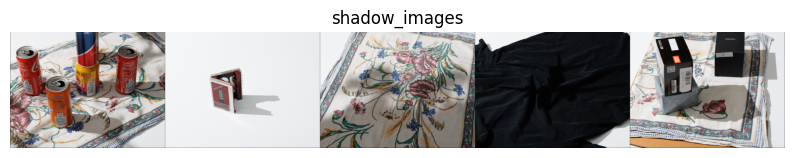

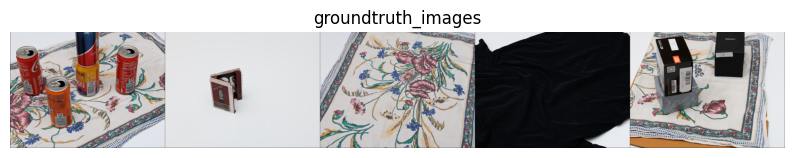

In [ ]:
imshow(torchvision.utils.make_grid(inputs.to(torch.uint8),nrow=5),title='shadow_images')
imshow(torchvision.utils.make_grid(targets.to(torch.uint8),nrow=5),title='groundtruth_images')

tensor([[[239.],
         [239.],
         [239.],
         [239.],
         [239.],
         [240.],
         [239.],
         [239.],
         [239.],
         [239.],
         [238.],
         [238.],
         [239.],
         [239.],
         [238.],
         [237.],
         [234.],
         [230.],
         [225.],
         [219.]],

        [[239.],
         [239.],
         [239.],
         [239.],
         [239.],
         [240.],
         [239.],
         [239.],
         [239.],
         [239.],
         [239.],
         [239.],
         [240.],
         [239.],
         [238.],
         [237.],
         [234.],
         [230.],
         [225.],
         [219.]],

        [[241.],
         [241.],
         [241.],
         [241.],
         [241.],
         [242.],
         [241.],
         [241.],
         [241.],
         [241.],
         [241.],
         [241.],
         [242.],
         [241.],
         [241.],
         [239.],
         [236.],
         [232.],
         [

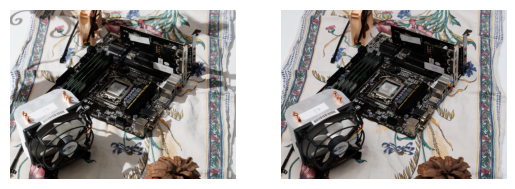

In [ ]:
X,Y = train.__getitem__(9)
print(X[:,50:70,:50:70])
X = np.moveaxis(X.numpy(),(0,1,2),(-1,0,1))
Y = np.moveaxis(Y.numpy(),(0,1,2),(-1,0,1))
# X = np.multiply(X,255.0).astype(np.uint8)
# Y = np.multiply(Y,255.0).astype(np.uint8)
# print(X[50:70,50:70,:])
plt.subplot(1,2,1)
plt.imshow(X.astype(np.uint8))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(Y.astype(np.uint8))
plt.axis('off')
plt.show()

In [ ]:
x = torch.tensor(X)
print(torch.div(x.to(torch.float),255.0))

tensor([[[0.9373, 0.9373, 0.9451],
         [0.9412, 0.9412, 0.9490],
         [0.9412, 0.9412, 0.9490],
         ...,
         [0.8706, 0.8745, 0.8824],
         [0.8824, 0.8863, 0.8941],
         [0.8863, 0.8902, 0.8980]],

        [[0.9412, 0.9412, 0.9490],
         [0.9373, 0.9373, 0.9451],
         [0.9373, 0.9373, 0.9451],
         ...,
         [0.8784, 0.8784, 0.8902],
         [0.8824, 0.8863, 0.8980],
         [0.8863, 0.8902, 0.8980]],

        [[0.9373, 0.9373, 0.9451],
         [0.9373, 0.9373, 0.9451],
         [0.9373, 0.9373, 0.9451],
         ...,
         [0.8863, 0.8902, 0.8980],
         [0.8863, 0.8902, 0.8980],
         [0.8863, 0.8902, 0.8980]],

        ...,

        [[0.8549, 0.8431, 0.8353],
         [0.8863, 0.8824, 0.8745],
         [0.8941, 0.8941, 0.8902],
         ...,
         [0.5882, 0.5922, 0.6000],
         [0.5882, 0.5922, 0.6000],
         [0.5882, 0.5922, 0.6000]],

        [[0.8549, 0.8471, 0.8392],
         [0.8863, 0.8824, 0.8745],
         [0.

In [ ]:
def reshape_ten(image:torch.tensor,sub_image_size:tuple):
  channels , img_height,img_width, = image.shape
  tile_height,tile_width = sub_image_size
  assert(img_height%tile_height==0 and img_width%tile_width==0)
  image = torch.moveaxis(image,(0,1,2),(2,0,1))
  image = image.reshape(img_height // tile_height, tile_height, img_width // tile_width, tile_width, channels)
  image = image.swapaxes(1,2)
  image = image.reshape(-1,tile_height,tile_width,channels)
  image = image.moveaxis((3,1,2),(1,2,3))
  return image

def reshape_img(ten:torch.tensor,img_size:tuple):
  n_tiles,n_channels,tile_height,tile_width = ten.shape
  img_h,img_w = img_size
  assert(img_h%tile_height==0 and img_w%tile_width==0)
  ten = ten.moveaxis((1,2,3),(3,1,2))
  ten = ten.reshape(img_h//tile_height,img_w//tile_width,tile_height,tile_width,n_channels)
  ten = ten.swapaxes(2,1)
  ten = ten.reshape(img_h,img_w,n_channels)
  ten = ten*255.0
  ten = ten.to(torch.uint8)

  return ten

TILE_SIZE = (360,640)
IMG_SIZE = (1440,1920)

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5,stride=1, padding=2,bias=False),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            nn.Conv2d(32,64,kernel_size=3,stride=2, padding=0,bias=False),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2,padding=0),
            nn.Conv2d(64,128,kernel_size=3,stride=2, padding=0,bias=False),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2,padding=0),
            nn.Conv2d(128,196,kernel_size=3,stride=2, padding=0,bias=False),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(196,128,kernel_size=3,stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32,kernel_size=3,stride=2,padding=0),
            nn.ReLU(),
            # nn.Conv2d(32, 32, kernel_size=3,stride=1,padding=1),
            # nn.ReLU(),
            nn.ConvTranspose2d(32,3,kernel_size=5,stride=1,padding=2),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3,stride=1,padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
def train_m(model, criterion, optimizer, train_loader, num_epochs,start_epoch=0,scheduler=None):
    model.train()
    for epoch in range(start_epoch,num_epochs):
        running_loss = 0.0
        total_batch = len(train_loader)
        for ind,data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(inputs.shape,labels.shape)
            # inputs = inputs.reshape(inputs.shape[1],inputs.shape[2],inputs.shape[3])
            # labels = labels.reshape(labels.shape[1],labels.shape[2],labels.shape[3])
            for i in range(inputs.shape[0]):
              # print(inputs[i,:,:,:].shape,labels[i,:,:,:].shape)
              img_in = reshape_ten(inputs[i,:,:,:],TILE_SIZE)
              img_tar = reshape_ten(labels[i,:,:,:],TILE_SIZE)
              optimizer.zero_grad()
              outputs = model(img_in)
              loss = criterion(outputs, img_tar)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()
            print(f"Batch [{(ind+1)}/{total_batch}], Loss: {running_loss / (ind+1)}")
        # if(scheduler):
        #   scheduler.step()
        # checkpoint = {"epoch":epoch,"model_state":model.state_dict(),"optimizer_state":optimizer.state_dict(),"scheduler_state":scheduler.state_dict()}
        checkpoint = {"epoch":epoch,"model_state":model.state_dict(),"optimizer_state":optimizer.state_dict()}
        torch.save(checkpoint,"/content/drive/MyDrive/Colab Notebooks/checkpoint_new.pth")
        print("----------------------------------------------------------------------------------")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader.dataset)}")

def test(model, criterion, test_loader):
    model.eval()
    with torch.no_grad():
        output_image_path ='/content/datasets/validate_output'
        os.makedir(output_image_path)
        img_count = 1
        for ind,inputs in enumerate(test_loader):
            for i in range(inputs.shape[0]):
              img_in = img_in.to(device)
              img_in = reshape_ten(inputs[i,:,:,:],TILE_SIZE)
              outputs = model(img_in)
              out_img = reshape_img(outputs)
              out_img = out_img.cpu().numpy()
              out_img = Image.fromarray(np.transpose(out_img,(1,2,0)))
              out_img.save(os.path.join(output_image_path,f"{img_count}.png"))
              img_count+=1
            print(f"Batch: {ind+1} / {len(test_loader)} done")


In [ ]:
def train_m(model, criterion, optimizer, train_loader, num_epochs,start_epoch=0,scheduler=None):
    model.train()
    for epoch in range(start_epoch,num_epochs):
        running_loss = 0.0
        total_batch = len(train_loader)
        for ind,data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(inputs.shape,labels.shape)
            # inputs = inputs.reshape(inputs.shape[1],inputs.shape[2],inputs.shape[3])
            # labels = labels.reshape(labels.shape[1],labels.shape[2],labels.shape[3])
            # for i in range(inputs.shape[0]):
            #   # print(inputs[i,:,:,:].shape,labels[i,:,:,:].shape)
            #   img_in = reshape_ten(inputs[i,:,:,:],TILE_SIZE)
            #   img_tar = reshape_ten(labels[i,:,:,:],TILE_SIZE)
            #   optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(labels,outputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Batch [{(ind+1)}/{total_batch}], Loss: {running_loss / (ind+1)}")
        # if(scheduler):
        #   scheduler.step()
        # checkpoint = {"epoch":epoch,"model_state":model.state_dict(),"optimizer_state":optimizer.state_dict(),"scheduler_state":scheduler.state_dict()}
        checkpoint = {"epoch":epoch,"model_state":model.state_dict(),"optimizer_state":optimizer.state_dict()}
        torch.save(checkpoint,"/content/drive/MyDrive/Colab Notebooks/checkpoint_new.pth")
        print("----------------------------------------------------------------------------------")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")


In [ ]:
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/checkpoint_new_lr.pth")
model.load_state_dict(checkpoint["model_state"])
# optimizer.load_state_dict(checkpoint["optimizer_state"])
# scheduler.load_state_dict(checkpoint["scheduler_state"])

<All keys matched successfully>

In [ ]:
BATCH_SIZE = 3
EPOCHS = 30
train_loader =  DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
num_epochs=EPOCHS
start_epoch=0

In [ ]:
model.train()
epoch_loss = []
for epoch in range(start_epoch,num_epochs):
    running_loss = 0.0
    total_batch = len(train_loader)
    for ind,data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(inputs.shape,labels.shape)
        # inputs = inputs.reshape(inputs.shape[1],inputs.shape[2],inputs.shape[3])
        # labels = labels.reshape(labels.shape[1],labels.shape[2],labels.shape[3])
        # for i in range(inputs.shape[0]):
        #   # print(inputs[i,:,:,:].shape,labels[i,:,:,:].shape)
        #   img_in = reshape_ten(inputs[i,:,:,:],TILE_SIZE)
        #   img_tar = reshape_ten(labels[i,:,:,:],TILE_SIZE)
        #   optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if((ind+1)%50==0):
          print(f"Batch [{(ind+1)}/{total_batch}], Loss: {running_loss / (ind+1)}")
    # if(scheduler):
    #   scheduler.step()
    # checkpoint = {"epoch":epoch,"model_state":model.state_dict(),"optimizer_state":optimizer.state_dict(),"scheduler_state":scheduler.state_dict()}
    checkpoint = {"epoch":epoch,"model_state":model.state_dict(),"optimizer_state":optimizer.state_dict()}
    torch.save(checkpoint,"/content/drive/MyDrive/Colab Notebooks/checkpoint_new.pth")
    epoch_loss.append((running_loss / len(train_loader)))
    print("----------------------------------------------------------------------------------")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    print("----------------------------------------------------------------------------------")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 3, 1440, 1920])) that is different to the input size (torch.Size([3, 3, 1439, 1919])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (1919) must match the size of tensor b (1920) at non-singleton dimension 3

In [ ]:
len(train_loader)

63

In [ ]:
63*16

1008

In [ ]:
!export TORCH_USE_CUDA_DSA=1
!export CUDA_LAUNCH_BLOCKING=1


In [ ]:
#MB per image
 (1440*1920*3*2*32)/10e6

53.08416

In [ ]:
def tensor_to_numpy(X:torch.tensor) -> np.ndarray:
  X = np.moveaxis(X.detach().cpu().numpy(),(0,1,2),(-1,0,1))
  return X


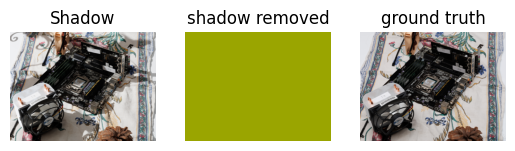

7.412404101668071


In [ ]:
with torch.no_grad():
  x,y = train.__getitem__(9)
  x =x.to(device)
  y = y.to(device)
  out = model(x)
  plot_images([tensor_to_numpy(x.cpu().to(torch.uint8)),tensor_to_numpy(out.cpu().to(torch.uint8)),tensor_to_numpy(y.cpu().to(torch.uint8))],['Shadow','shadow removed','ground truth'])
  print(cv2.PSNR((tensor_to_numpy(out.cpu().to(torch.uint8))),(tensor_to_numpy(y.cpu().to(torch.uint8)))))

In [ ]:
out.cpu().to(torch.uint8)

tensor([[[154, 154, 154,  ..., 154, 154, 154],
         [154, 154, 154,  ..., 154, 154, 154],
         [154, 154, 154,  ..., 154, 154, 154],
         ...,
         [154, 154, 154,  ..., 154, 154, 154],
         [154, 154, 154,  ..., 154, 154, 154],
         [154, 154, 154,  ..., 154, 154, 154]],

        [[165, 165, 165,  ..., 165, 165, 165],
         [165, 165, 165,  ..., 165, 165, 165],
         [165, 165, 165,  ..., 165, 165, 165],
         ...,
         [165, 165, 165,  ..., 165, 165, 165],
         [165, 165, 165,  ..., 165, 165, 165],
         [165, 165, 165,  ..., 165, 165, 165]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]], dtype=torch.uint8)

In [ ]:
x[:,5:10,5:10]

tensor([[[0.6779, 0.6547, 0.6778, 0.6547, 0.6778],
         [0.6543, 0.6811, 0.6543, 0.6810, 0.6542],
         [0.6780, 0.6548, 0.6780, 0.6548, 0.6778],
         [0.6544, 0.6812, 0.6543, 0.6811, 0.6542],
         [0.6780, 0.6548, 0.6780, 0.6548, 0.6779]],

        [[0.5733, 0.5890, 0.5733, 0.5890, 0.5733],
         [0.5881, 0.5572, 0.5881, 0.5572, 0.5881],
         [0.5734, 0.5891, 0.5733, 0.5890, 0.5733],
         [0.5882, 0.5573, 0.5882, 0.5572, 0.5881],
         [0.5734, 0.5892, 0.5735, 0.5891, 0.5733]],

        [[0.6400, 0.6428, 0.6399, 0.6427, 0.6399],
         [0.6518, 0.6329, 0.6517, 0.6329, 0.6517],
         [0.6401, 0.6428, 0.6400, 0.6428, 0.6400],
         [0.6518, 0.6329, 0.6518, 0.6329, 0.6518],
         [0.6401, 0.6429, 0.6401, 0.6429, 0.6400]]], grad_fn=<SliceBackward0>)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
gc.collect()

420

In [ ]:
!nvidia-smi

Fri Mar 29 03:18:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0              29W /  70W |   9679MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!kill 5220

/bin/bash: line 1: kill: (5220) - No such process


In [ ]:
print(torch.cuda.memory_summary(device=device, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   9286 MiB |   9375 MiB |  14543 MiB |   5257 MiB |
|       from large pool |   9284 MiB |   9373 MiB |  14540 MiB |   5256 MiB |
|       from small pool |      2 MiB |      3 MiB |      3 MiB |      0 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   9286 MiB |   9375 MiB |  14543 MiB |   5257 MiB |
|       from large pool |   9284 MiB |   9373 MiB |  14540 MiB |

In [ ]:
del model,inputs,targets,outputs

In [ ]:
torch.cuda.memory_reserved()

15227420672

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [ ]:
!sudo kill -5220 pid